#  Running AOS on AuxTel - main points

I find on which night defocal exposures were taken from the Observers Log, eg. https://confluence.lsstcorp.org/display/LSSTCOM/2021-06-08+Aux-Tel+Night+Log
    

Find dataset refs for these observations:

In [1]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/')
registry = butler.registry
datasetRefs = list(registry.queryDatasets(instrument='LATISS', datasetType='raw', collections=['LATISS/raw/all'],
                                          where="exposure.day_obs=20210608"
                                         ))
datasetRefs[0]

DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LATISS', detector: 0, exposure: 2021060800001, ...}, id=bfad0366-9915-5a37-b6f0-d42752929172, run='LATISS/raw/all')

I pick one intra - 2021060800400 and one extra - 2021060800401 exposure.

Show the raw exposures. Print `FOCUSZ` to show the offset:

In [4]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
exposure_intra = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800400},
                      collections=['LATISS/raw/all'])
print(exposure_intra.getMetadata()['FOCUSZ'])

exposure_extra = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800401},
                      collections=['LATISS/raw/all'])

print(exposure_extra.getMetadata()['FOCUSZ'])



/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000400-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


-0.770438730716705


/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000401-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


0.829561293125153


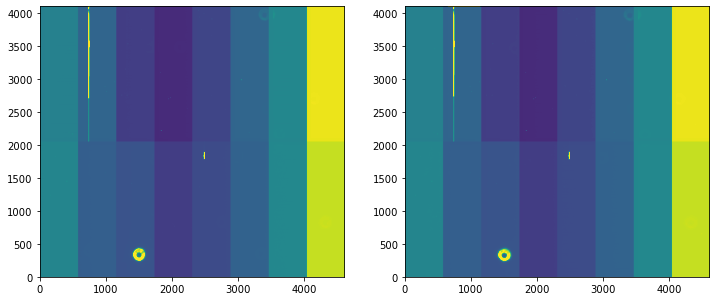

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax  = plt.subplots(1,2,figsize=(12, 10))
ax[0].imshow(exposure_extra.image.array, origin='lower',vmax=20000)# vmax=50)
mappable = ax[1].imshow(exposure_intra.image.array, origin='lower',vmax=20000)
#plt.colorbar(mappable,ax=ax[1])

Run the ISR : 

    pipetask run  --data-query "exposure IN (2021060800400,2021060800401) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISR11 --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types

Where the config yaml contained 

    isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'

Show the postISR : 

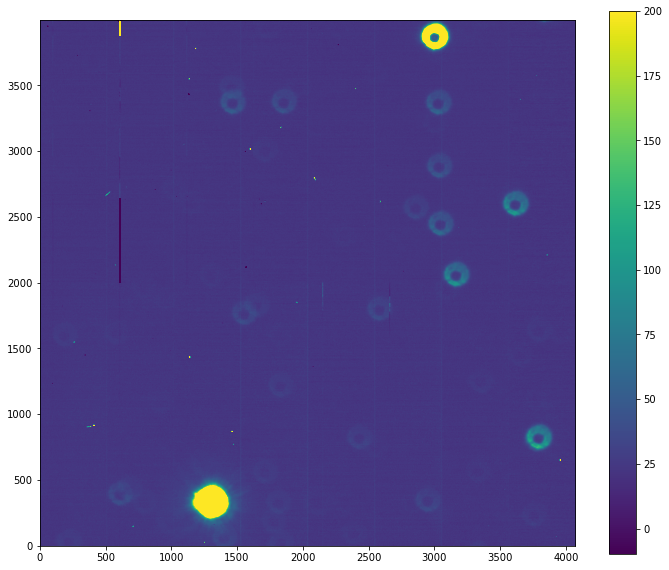

In [14]:
%matplotlib inline
from astropy.io import fits
hdula = fits.open('/repo/main/u/scichris/Latiss/postISR11/\
20210901T225749Z/postISRCCD/20210608/AT_O_20210608_000400/\
postISRCCD_LATISS_RG610~empty_AT_O_20210608_000400_RXX_S00_u_scichris_Latiss_postISR11_20210901T225749Z.fits'
                 )
fig = plt.figure(figsize=(12, 10))
plt.imshow(hdula[1].data, origin='lower',vmin=-10,vmax=200)
plt.colorbar()

### Create the donut catalog 

#### Set configurations for the task

Load the `ts_wep` modules

In [27]:
from lsst.ts.wep.task.GenerateDonutCatalogOnlineTask import (GenerateDonutCatalogOnlineTask, 
                                                             GenerateDonutCatalogOnlineTaskConfig)

Get the boresight and pointing angle from the raw exposure 

In [28]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/')
rawImage = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800400},
                      collections=['LATISS/raw/all'])

/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000400-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


In [29]:
rawImVisitInfo = rawImage.getInfo().getVisitInfo()
print(f"Boresight Ra, Dec is: {rawImVisitInfo.getBoresightRaDec()}, Boresight Rotation Angle in degrees is: {rawImVisitInfo.getBoresightRotAngle().asDegrees()}")

Boresight Ra, Dec is: (297.8343896415, -58.4925471458), Boresight Rotation Angle in degrees is: 25.7151863184216


Pass the boresight information to `ts_wep` : 

In [31]:
donutCatConfig = GenerateDonutCatalogOnlineTaskConfig()
donutCatConfig.boresightRa = rawImVisitInfo.getBoresightRaDec().getRa().asDegrees()
donutCatConfig.boresightDec = rawImVisitInfo.getBoresightRaDec().getDec().asDegrees()
donutCatConfig.boresightRotAng = rawImVisitInfo.getBoresightRotAngle().asDegrees()
donutCatConfig.filterName = 'phot_g_mean'

In [32]:
donutCatConfig

lsst.ts.wep.task.GenerateDonutCatalogOnlineTask.GenerateDonutCatalogOnlineTaskConfig(saveMetadata=True, saveLogOutput=True, filterName='phot_g_mean', cameraName='lsstCam', connections={'refCatalogs': 'cal_ref_cat', 'donutCatalog': 'donutCatalog'}, boresightRa=297.834389641502, boresightDec=-58.4925471458268, boresightRotAng=25.7151863184216)

In [63]:
# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogOnlineTask(config=donutCatConfig)

#### Prepare the data for the task

Need to get the reference catalog get available to `butler` repository: 

In [19]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
registry = butler.registry

deferredList = []
datasetGenerator = registry.queryDatasets(datasetType="gaia_dr2_20200414", 
                                          collections=["refcats"]).expanded()
for ref in datasetGenerator:
    deferredList.append(butler.getDeferred(ref, collections=["refcats"]))

Change the mapping of the object loader and run the task to retrieve the reference object catalog:

In [ ]:
camera = "LATISS"
refObjLoader = donutCatTask.getRefObjLoader(deferredList)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }


donutCatStruct = donutCatTask.run(camera, deferredList)

Compare the wcs attached to the exposure to a wcs created by `GenerateDonutCatalogOnlineTask`:

In [64]:
donutCatTask.boresightPointing

SpherePoint(297.834389641502*geom.degrees, -58.4925471458268*geom.degrees)

In [65]:
from lsst.obs.base import createInitialSkyWcsFromBoresight
import lsst.obs.lsst as obs_lsst
import lsst.geom

camera = obs_lsst.Latiss.getCamera()
for detector in camera:
    
    detWcs = createInitialSkyWcsFromBoresight(
                donutCatTask.boresightPointing,
                donutCatTask.boresightRotAng * lsst.geom.degrees,
                detector,
                flipX=False,
            )


In [67]:
detWcs

FITS standard SkyWcs:
Sky Origin: (297.8343896415, -58.4925471458)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [70]:
rawImage.getWcs()

FITS standard SkyWcs:
Sky Origin: (297.8343896415, -58.4925471458)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

They are exactly the same! So the problem is not here ... 

We can get the donutCatalog out of it by specifying the property donutCatalog.

In [ ]:
donutCatalog = donutCatStruct.donutCatalog
donutCatalog.head()

I save it to avoid the lengthy query above next time 

In [ ]:
import pandas as pd
donutCatalog.to_csv('GAIA_donut_catalog.csv')

### Running the Zernike Estimation

In [173]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'paraxial'

In [174]:
estimateZernikeTask.opticalModel

'paraxial'

In [175]:
estimateZernikeTask.donutStampSize

200

Figure out what refs are available for the `postISR` image  from the butler :

In [4]:
exposure


In [64]:
from lsst.daf import butler as dafButler
instrument = 'LATISS'
dataId0 = dict(instrument=instrument)
repo_dir = '/repo/main/'
butler = dafButler.Butler(repo_dir, collections=['run1'])
                          
dataset = next(iter(
                butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['u/scichris/Latiss/postISR11'],
                    dataId=dataId0  )
                )
           )

expN = dataset.dataId["exposure"]

# Get the refs  for this dataset
refs = []
for ref in butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['u/scichris/Latiss/postISR11'],
                    dataId=dataId0  ):
    refs.append(ref)

In [5]:
refs[0].dataId

{instrument: 'LATISS', detector: 0, exposure: 2021060800401, ...}

Read in the two  postISR exposures - one is intra, the other extra-focal, but we don't need to know as the code will figure it out based on `FOCUSZ`:

In [65]:
exp1 = butler.get(datasetRefOrType='postISRCCD',dataId=refs[0].dataId,
              collections=['u/scichris/Latiss/postISR11'])

exp2 = butler.get(datasetRefOrType='postISRCCD',dataId=refs[1].dataId,
              collections=['u/scichris/Latiss/postISR11'])

# %matplotlib inline
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# ax[0].imshow(exp1.image.array, origin='lower', vmin=-10,vmax=200)
# ax[1].imshow(exp2.image.array, origin='lower', vmin=-10,vmax=200)

Store as an exposure pair passed to `ts_wep` : 

In [66]:
expPair = [exp1,exp2]

### Run Task

A) Use the previously read-in donut catalog based on the GAIA catalog queried at the location given by the WCS information

In [6]:
import pandas as pd
donutCatalog = pd.read_csv('GAIA_donut_catalog.csv')

In [6]:
donutCatalog

Unnamed: 0  coord_ra  coord_dec   centroid_x   centroid_y   source_flux  \
0             0  5.198804  -1.021757   653.219991   615.972550  5.052877e+04   
1             1  5.196814  -1.021203  3189.238069   720.084519  2.360729e+04   
2             2  5.198801  -1.021199  1177.698091  1698.170744  1.386361e+04   
3             3  5.197345  -1.020926  2910.604693  1517.382422  1.437050e+04   
4             4  5.198023  -1.021826  1380.952142   101.916337  2.045614e+04   
..          ...       ...        ...          ...          ...           ...   
216         216  5.197414  -1.019989  3717.629063  3371.528097  1.149424e+05   
217         217  5.198141  -1.019966  3001.092591  3771.676609  2.125025e+04   
218         218  5.198302  -1.019944  2856.975187  3893.273769  2.146822e+05   
219         219  5.197747  -1.020624  2784.215180  2300.431841  4.683922e+05   
220         220  5.197157  -1.020112  3862.987955  3005.828752  6.738969e+06   

    detector  
0    RXX_S00  
1    RXX_S00  
2    RXX_S00  
3    RXX_S00  
4    RXX_S00  
..       ...  
216  RXX_S00  
217  RXX_S00  
218  RXX_S00  
219  RXX_S00  
220  RXX_S00  

[221 rows x 7 columns]

Try imparting a magnitude cut on the input source catalog

In [15]:
import numpy as np
# I believe flux is in nanoJanskys 
# https://github.com/lsst/meas_algorithms/blob/2eca8e6affe861eb8ff1adaf11d13d679d3912e6/python/lsst/meas/algorithms/loadReferenceObjects.py#L505
# -2.5*np.log10(1e-9) = 22.5
# the formula https://en.wikipedia.org/wiki/AB_magnitude
# is for flux in Jy:
# mags = -2.5 *log10(flux[Jy]) + 8.9
# nJy = 1e-9 Jy
# so flux[nJy] = 1e-9 flux[Jy]
mags= -2.5*np.log10(donutCatalog['source_flux'])+22.5 +8.9

Text(0.5, 0, 'mag')

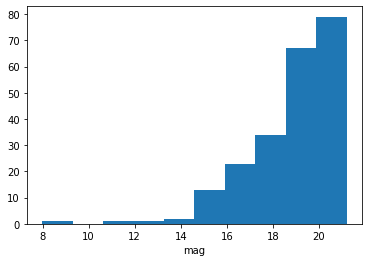

In [18]:
import matplotlib.pyplot as plt
plt.hist(mags)
plt.xlabel('mag')

In [101]:
# make a donut catalog with  a mag cut of 18 mag ..
import numpy as np
mags= -2.5*np.log10(donutCatalog['source_flux'])+22.5 +8.9
donutCatalog['mags'] = mags
mask = mags<16
donutCatalogMagCut = donutCatalog[mask]
donutCatalogMagCut

Unnamed: 0  coord_ra  coord_dec   centroid_x   centroid_y   source_flux  \
5             5  5.197707  -1.021753  1768.673025    90.093446  2.130389e+06   
9             9  5.198467  -1.021066  1640.898395  1794.122656  1.654542e+06   
24           24  5.198979  -1.021361   845.813611  1471.089404  1.651773e+06   
26           26  5.198443  -1.021196  1543.064549  1530.195793  2.328102e+09   
40           40  5.199659  -1.020839   642.301746  2816.091466  4.857964e+06   
44           44  5.200176  -1.020377   547.709585  3966.025430  2.299344e+06   
69           69  5.199116  -1.020755  1272.643209  2715.853626  2.177633e+06   
116         116  5.198989  -1.020979  1192.502994  2217.952298  3.157569e+07   
137         137  5.196868  -1.021564  2795.882911    46.035735  1.947863e+06   
147         147  5.197025  -1.020041  4064.125695  3077.935051  7.308493e+07   
148         148  5.196701  -1.020501  3962.110103  2026.656363  2.313729e+06   
149         149  5.196966  -1.020635  3567.386683  1895.729556  1.643959e+06   
154         154  5.198581  -1.020361  2183.582959  3219.498183  4.616078e+06   
160         160  5.196261  -1.020917  4018.462168  1004.952440  1.291427e+07   
182         182  5.196282  -1.020912  4002.003762  1024.592582  1.825133e+06   
194         194  5.197118  -1.020882  3181.708797  1492.891303  1.956328e+06   
215         215  5.198371  -1.019996  2738.763710  3825.836867  2.606042e+06   
220         220  5.197157  -1.020112  3862.987955  3005.828752  6.738969e+06   

    detector       mags  
5    RXX_S00  15.578853  
9    RXX_S00  15.853306  
24   RXX_S00  15.855124  
26   RXX_S00   7.982495  
40   RXX_S00  14.683864  
44   RXX_S00  15.495990  
69   RXX_S00  15.555038  
116  RXX_S00  12.651618  
137  RXX_S00  15.676104  
147  RXX_S00  11.740430  
148  RXX_S00  15.489219  
149  RXX_S00  15.860272  
154  RXX_S00  14.739317  
160  RXX_S00  13.622325  
182  RXX_S00  15.746764  
194  RXX_S00  15.671396  
215  RXX_S00  15.360046  
220  RXX_S00  14.328516

In [50]:
wcs = exp1.getWcs()

# calculate the position given the x,y 
x,y = `


In [60]:
wcs

FITS standard SkyWcs:
Sky Origin: (297.8344232447, -58.4925827471)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

4174.823221681017


Text(0, 0.5, 'y')

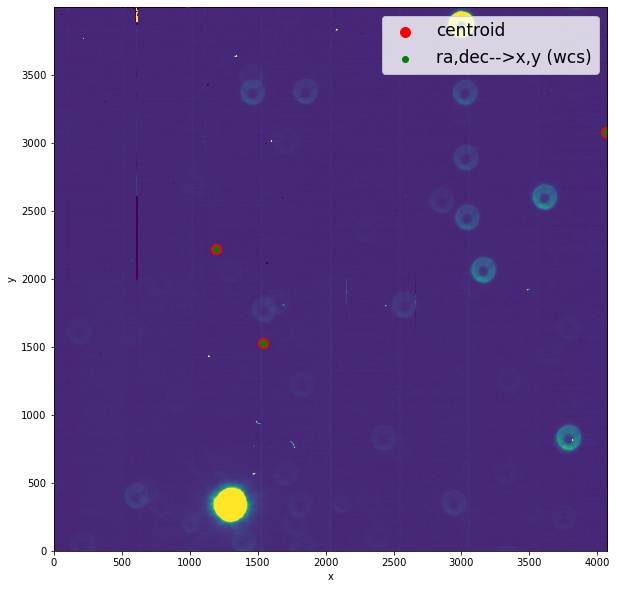

In [94]:
# Before passing this to estimateZernikeTask, plot the location of the donutCatalog donuts
# on top of the postISR image ... 
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(exp1.image.array,vmin=0,vmax=200, origin='lower')
d = np.mean(donutCatalogMagCut['centroid_x'] + x)
print(d)
ax.scatter(donutCatalogMagCut['centroid_x'], donutCatalogMagCut['centroid_y'], label='centroid',
          c='red',s=100)
ax.scatter(-x+d,y, label='ra,dec-->x,y (wcs)',c='green')
ax.legend(fontsize=17)
ax.set_xlabel('x')
ax.set_ylabel('y')

Plot the `ra,dec` axes on the image and get the ra,dec of the donut in the GAIA catalog

In [24]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

def plotRaDec(postIsrExp):
    
    """
    Plot the image data and the WCS overlay.
    
    Parameters
    ----------
    postIsrExp : lsst.afw.image.Exposure
        The post-ISR exposure from the butler repository.
    """
    # Get the WCS for the projection
    wcs = postIsrExp.getWcs()
    header_dict = dict(wcs.getFitsMetadata())
    
    # Add in axis information
    header_dict['NAXIS'] = 2
    header_dict['NAXIS1'] = 4072
    header_dict['NAXIS2'] = 4000
    
    # Convert to astropy readable WCS
    astropyWcs = WCS(header_dict)
    
    # Grab image data and plot
    data = postIsrExp.getImage().getArray()
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    plt.subplot(projection=astropyWcs)#, slices=('y', 'x'))
    plt.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys',)

    # Format coordinates presentation
    ax = plt.gca()

    # Fix axis label issue (https://github.com/astropy/astropy/issues/7180)
    ax.coords[0].set_ticklabel_position('l')
    ax.coords[0].grid(color='yellow')
    ax.set_ylabel('RA')
    
    ax.coords[1].set_ticklabel_position('b')
    ax.coords[1].grid(color='yellow')
    ax.set_xlabel('Dec')

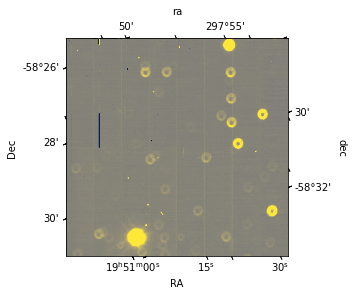

In [133]:
wcs = exp1.getWcs()
header_dict = dict(wcs.getFitsMetadata())

header_dict['NAXIS'] = 2
header_dict['NAXIS1'] = 4072
header_dict['NAXIS2'] = 4000

astropyWcs = WCS(header_dict)

data = exp1.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
    
    
ax = plt.subplot(projection=astropyWcs)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('fk5')
#overlay.grid(color='white', ls='dotted')


In [126]:
astropyWcs.world_axis_units

['deg', 'deg']

In [112]:
a = np.rad2deg(donutCatalogMagCut['coord_ra'].values)

In [121]:
donutCatalogMagCut[['coord_ra_deg','coord_dec_deg']]

coord_ra_deg  coord_dec_deg
5      297.806701     -58.542112
9      297.850207     -58.502777
24     297.879544     -58.519677
26     297.848869     -58.510227
40     297.918513     -58.489793
44     297.948138     -58.463321
69     297.887409     -58.484940
116    297.880112     -58.497791
137    297.758610     -58.531300
147    297.767580     -58.444065
148    297.749016     -58.470408
149    297.764190     -58.478106
154    297.856772     -58.462380
160    297.723825     -58.494208
182    297.725014     -58.493929
194    297.772945     -58.492206
215    297.844716     -58.441457
220    297.775189     -58.448116

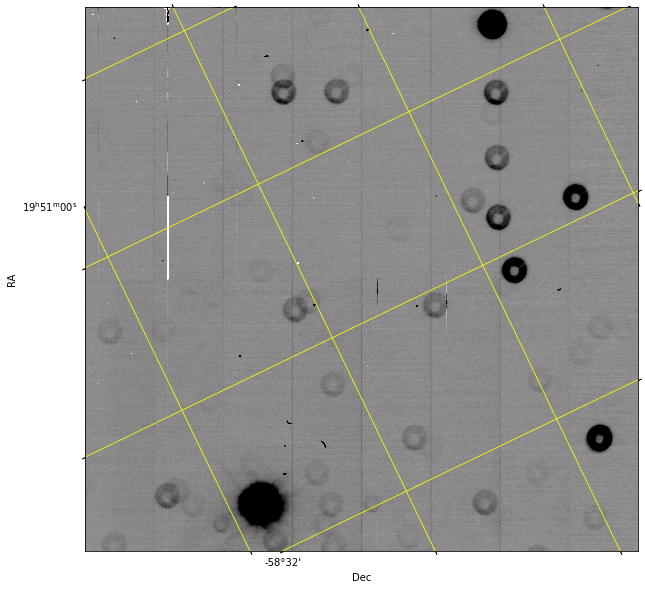

In [119]:
fig = plt.figure(figsize=(10,10))
plotRaDec(exp1)
#donutCatalogMagCut['coord_ra_deg'] = np.rad2deg(donutCatalogMagCut['coord_ra'].values)
#donutCatalogMagCut['coord_dec_deg'] = np.rad2deg(donutCatalogMagCut['coord_dec'].values)
#plt.scatter(donutCatalogMagCut['coord_ra_deg'], donutCatalogMagCut['coord_dec_deg'])

B ) Try detecting donuts in an exposure, following https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/Create_wcs_from_phosim_out_of_focus_no_transpose.ipynb and this code https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/DonutDetector.py to run donut detection

### Get the donut template

In [58]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'

Get the template 

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType

# get the defocal exposure...
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', collections=['u/scichris/Latiss/postISR11'])
exposure  = butler.get(datasetRefOrType='postISRCCD',
                       dataId={'detector':"RXX_S00",'exposure':2021060800401})


# make template 
detectorName = exposure.getDetector().getName()
pixelScale = exposure.getWcs().getPixelScale().asArcseconds()
defocalType = DefocalType.Extra
template = estimateZernikeTask.getTemplate(detectorName, defocalType, pixelScale)

In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885


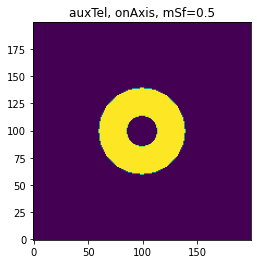

In [4]:
plt.imshow(template,origin='lower')
plt.title('auxTel, onAxis, mSf=0.5')
plt.savefig('auxTel_onAxis_maskScalingFactorLocal-05.png')

# [aside] inside DonutTemplateModel

In [122]:
import os
import numpy as np
from lsst.ts.wep.Utility import getConfigDir, readPhoSimSettingData, CamType
from lsst.ts.wep.cwfs.DonutTemplateDefault import DonutTemplateDefault
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
import lsst.obs.lsst as obs_lsst
import lsst.geom as geom
import lsst.afw.cameraGeom as cameraGeom



# Get the butler defocal exposure 
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', collections=['u/scichris/Latiss/postISR11'])
exposure  = butler.get(datasetRefOrType='postISRCCD',
                       dataId={'detector':"RXX_S00",'exposure':2021060800401})


# DonutTemplateModel 

# DonutTemplate settings 
camType = CamType.AuxTel
imageSize = 200

# Common parts 
detectorName = exposure.getDetector().getName()
pixelScale = exposure.getWcs().getPixelScale().asArcseconds()

sensorName = detectorName   

configDir = getConfigDir()

# Load Instrument parameters
instDir = os.path.join(configDir, "cwfs", "instData")
inst = Instrument(instDir)


###  for LATISS 
if camType == CamType.AuxTel:
    # need to set optical model to paraxial 
    #opticalModel="paraxial"
    opticalModel ="paraxial"
    # Defocal distance for Latiss in mm 
    # for LsstCam can use the default,
    # hence only need to set here 
    announcedDefocalDisInMm = 0.8   

    inst.config(camType, imageSize, announcedDefocalDisInMm)
    # load the info for auxTel 
    pixelSizeInMeters = inst.getCamPixelSize()  # pixel size in meters. 
    pixelSizeInUm = pixelSizeInMeters * 1e6

    camera = obs_lsst.Latiss.getCamera()
    detector = camera.get(sensorName) # only one detector in latiss 
    bbox = detector.getBBox()
    xp, yp = detector.getCenter(cameraGeom.FOCAL_PLANE)  # center of CCD in mm 

    # multiply by 1000 to for mm --> microns conversion
    sensorXMicron = yp * 1000  
    sensorYMicron = xp * 1000 
else: 
    raise ValueError("Camera type (%s) is not supported." % camType)
       

### common parts 

# Create image for mask
img = CompensableImage()

# Convert pixel locations to degrees
sensorXPixel = float(sensorXMicron) / pixelSizeInUm
sensorYPixel = float(sensorYMicron) / pixelSizeInUm

# Multiply by pixelScale then divide by 3600 for arcsec->deg conversion
sensorXDeg = sensorXPixel * pixelScale / 3600
sensorYDeg = sensorYPixel * pixelScale / 3600
fieldXY = [sensorXDeg, sensorYDeg]

# Define position of donut at center of current sensor in degrees
boundaryT = 0
maskScalingFactorLocal = 1.
img.setImg(fieldXY, defocalType, image=np.zeros((imageSize, imageSize)))
print(f'In DonutTemplateModel using opticalModel {opticalModel}')
print(f'and maskScalingFactorLocal={maskScalingFactorLocal}')
img.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

template  = img.getNonPaddedMask()

In DonutTemplateModel using opticalModel paraxial
and maskScalingFactorLocal=1.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=1.0

 rMask:
0.0013194444444444443


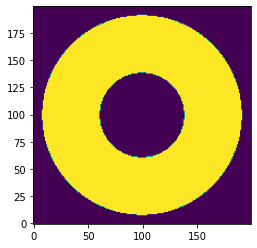

In [123]:
plt.imshow(img.getPaddedMask(), origin='lower')

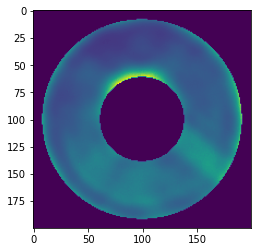

In [56]:
plt.imshow(img.getPaddedMask()/data)

In [ ]:
Cut out a donut by hand ... 

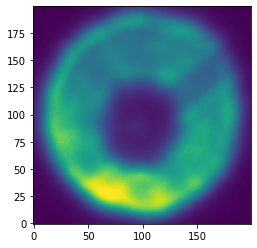

In [53]:
from astropy.visualization import ZScaleInterval
radius = 100
xcen = 1300
ycen = 340
zscale = ZScaleInterval()
data = exposure.image.array[ycen-radius:ycen+radius,
                            xcen-radius:xcen+radius,]
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, origin='lower',vmin=vmin,vmax=vmax)

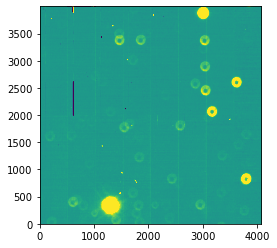

In [29]:
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, origin='lower',vmin=vmin, vmax=vmax)

In [60]:
from lsst.ts.wep.DonutDetector import DonutDetector
detector = DonutDetector()

from copy import copy
expArray = copy(exposure.getImage().getArray())
expArray[expArray < 0] = 0
expArray[expArray > 50] = 50

donutDf = detector.detectDonuts(expArray,template,blendRadius=100,
                               peakThreshold=0.9)

In [61]:
donutDf

x_center  y_center  blended blended_with  num_blended_neighbors
0       289      1311    False         None                      0
1      3867      2993    False         None                      0
2       830      3783    False         None                      0
3      2601      3607    False         None                      0
4      2065      3156    False         None                      0
5      2449      3038    False         None                      0
6      3367      3022    False         None                      0
7      3371      1459    False         None                      0

In [70]:
donutCat = donutDf.copy()

In [71]:
# need  to rename columns 
# as we EstimateZernikes 
# expects different names 
#Unnamed: 0	coord_ra	coord_dec	centroid_x	centroid_y	source_flux	detector	mags

# also, need to transpose y--> x 
donutCat = donutCat.rename(columns={"y_center":"centroid_x", "x_center":"centroid_y"})

In [72]:
donutCat['detector'] = "RXX_S00"

In [73]:
donutCat

centroid_y  centroid_x  blended blended_with  num_blended_neighbors  \
0         289        1311    False         None                      0   
1        3867        2993    False         None                      0   
2         830        3783    False         None                      0   
3        2601        3607    False         None                      0   
4        2065        3156    False         None                      0   
5        2449        3038    False         None                      0   
6        3367        3022    False         None                      0   
7        3371        1459    False         None                      0   

  detector  
0  RXX_S00  
1  RXX_S00  
2  RXX_S00  
3  RXX_S00  
4  RXX_S00  
5  RXX_S00  
6  RXX_S00  
7  RXX_S00

(array([1117089., 2868775., 4782519., 4318317., 2199145.,  662923.,
         144266.,   40126.,   21685.,  133155.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.],
       dtype=float32),
 <BarContainer object of 10 artists>)

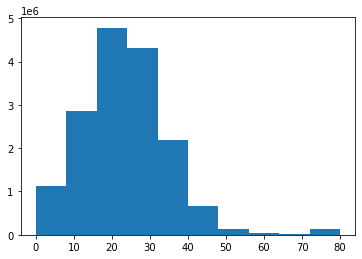

In [26]:
import numpy as np 
plt.hist(np.ravel(expArray))

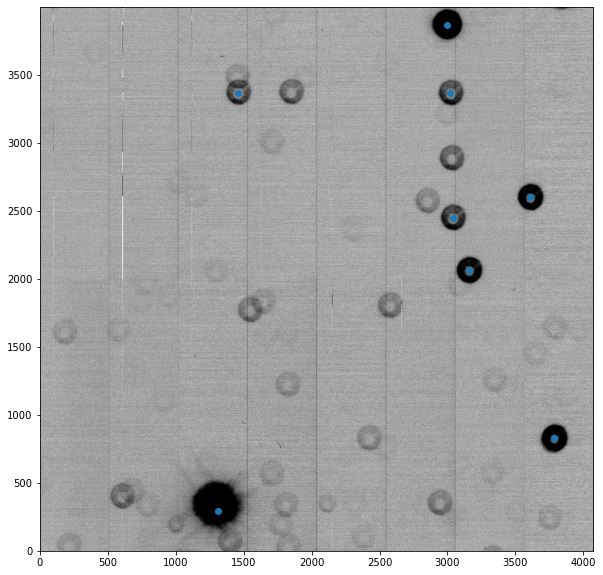

In [62]:
from astropy.visualization import ZScaleInterval
data = expArray
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(donutDf['y_center'], donutDf['x_center'])

#ax.imshow(template,alpha=0.1)

Write `cutoutStamps` without using the coord_ra, coord_dec. Take part of `EstimateZernikesLatissTask` which calls `EstimateZernikesBase`



In [67]:
exposures = expPair 

focusZ0 = exposures[0].getMetadata()["FOCUSZ"]
focusZ1 = exposures[1].getMetadata()["FOCUSZ"]

extraExpIdx, intraExpIdx = estimateZernikeTask.assignExtraIntraIdx(focusZ0, focusZ1)

Next we call 

    donutStampsExtra = self.cutOutStamps(
            exposures[extraExpIdx], donutCatalog, DefocalType.Extra, cameraName
        )
    
but I need to edit that to make the stamps without reference to the ra,dec. The original signature is 

    def cutOutStamps(self, exposure, donutCatalog, defocalType, cameraName):




In [74]:
from lsst.ts.wep.Utility import getConfigDir, DonutTemplateType, DefocalType, CamType

cameraName = "LATISS"
donutCatalog = donutCat
exposure = exposures[extraExpIdx]
defocalType = DefocalType.Extra

# first few lines of cutOutStamps 
detectorName = exposure.getDetector().getName()
pixelScale = exposure.getWcs().getPixelScale().asArcseconds()
template = estimateZernikeTask.getTemplate(detectorName, defocalType, pixelScale)
detectorCatalog = donutCatalog.query(f'detector == "{detectorName}"')


In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885


In [186]:
initialCutoutSize

280

In [75]:
# Initial list of cutouts
initialCutouts = []

# Final list of DonutStamp objects
finalStamps = []

finalCutouts = []

# Final locations of donut centroids in pixels
finalXCentList = []
finalYCentList = []

# Final locations of BBox corners for DonutStamp images
xCornerList = []
yCornerList = []

for donutRow in detectorCatalog.to_records():
    # Make an initial cutout larger than the actual final stamp
    # so that we can centroid to get the stamp centered exactly
    # on the donut
    xCent = int(donutRow["centroid_x"])
    yCent = int(donutRow["centroid_y"])
    
    # save initial centroids
    expDim = exposure.getDimensions()
    initialCutoutSize = estimateZernikeTask.donutStampSize + (2 * estimateZernikeTask.initialCutoutPadding)
    initialHalfWidth = int(initialCutoutSize / 2)
    stampHalfWidth = int(estimateZernikeTask.donutStampSize / 2)

    # Stamp BBox defined by corner pixel and extent
    initXCorner = xCent - initialHalfWidth
    initYCorner = yCent - initialHalfWidth
    
    # Define BBox and get cutout from exposure
    initCornerPoint = lsst.geom.Point2I(initXCorner, initYCorner)
    initBBox = lsst.geom.Box2I(
        initCornerPoint, lsst.geom.Extent2I(initialCutoutSize)
    )
    #initialCutout = exposure[initBBox]
    #initialCutouts.append(initialCutout)
    
    # Adjust the centroid coordinates from the catalog by convolving
    # the postage stamp with the donut template and return
    # the new centroid position as well as the corners of the
    # postage stamp to cut out of the exposure.
    finalDonutX, finalDonutY, xCorner, yCorner = estimateZernikeTask.calculateFinalCentroid(
            exposure, template, xCent, yCent)

    finalXCentList.append(finalDonutX)
    finalYCentList.append(finalDonutY)

    # Get the final cutout
    finalCorner = lsst.geom.Point2I(xCorner, yCorner)
    finalBBox = lsst.geom.Box2I(
        finalCorner, lsst.geom.Extent2I(estimateZernikeTask.donutStampSize)
    )
    xCornerList.append(xCorner)
    yCornerList.append(yCorner)

    finalCutout = exposure[finalBBox]
    finalCutouts.append(finalCutout)

NameError: name 'lsst' is not defined

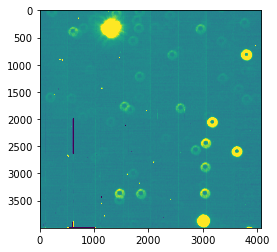

In [166]:
plt.imshow(exposure.image.array,vmin=vmin,vmax=vmax)

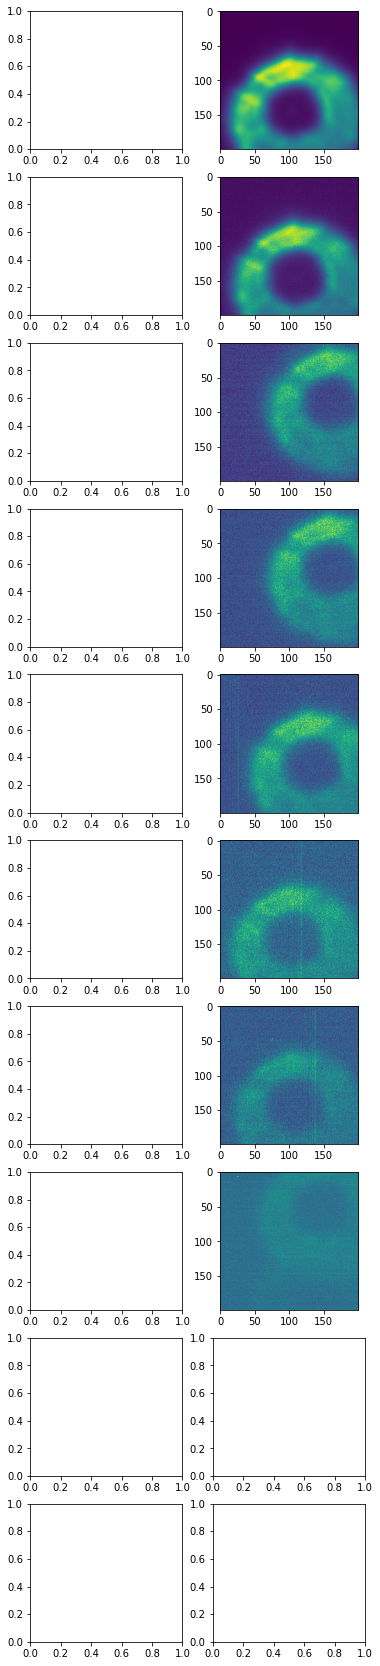

In [182]:
fig,ax = plt.subplots(10,2, figsize=(6,30))
for row in range(len(finalCutouts)):
    #ax[row,0].imshow(initialCutouts[row].image.array)
    ax[row,1].imshow(finalCutouts[row].image.array)

In [147]:
finalCutouts[0]

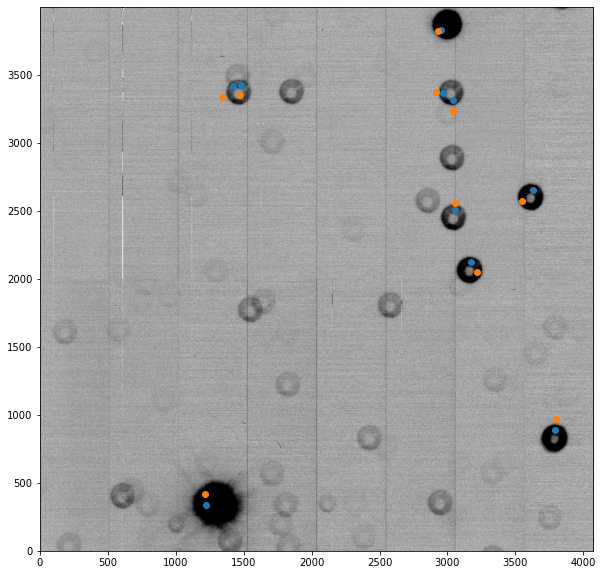

In [128]:
from astropy.visualization import ZScaleInterval
data = expArray
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(donutDf['y_center'], donutDf['x_center'])
ax.scatter(finalYCentList, finalXCentList, )
#ax.imshow(template,alpha=0.1)

In [121]:
xCent

3418

In [122]:
yCent

1421

In [124]:
finalDonutX

3338

In [125]:
finalDonutY

1340

In [41]:
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps


In [43]:
DonutStamp?


In [ ]:


# Save MaskedImage to stamp
finalStamp = finalCutout.getMaskedImage()
finalStamps.append(
    DonutStamp(
        stamp_im=finalStamp,
        sky_position=lsst.geom.SpherePoint(
            donutRow["coord_ra"],
            donutRow["coord_dec"],
            lsst.geom.radians,
        ),
        centroid_position=lsst.geom.Point2D(finalDonutX, finalDonutY),
        detector_name=detectorName,
        cam_name=cameraName,
        defocal_type=defocalType.value,
    )

In [116]:


for donutRow in detectorCatalog.to_records():
    # Make an initial cutout larger than the actual final stamp
    # so that we can centroid to get the stamp centered exactly
    # on the donut
    xCent = int(donutRow["centroid_x"])
    yCent = int(donutRow["centroid_y"])

    # Adjust the centroid coordinates from the catalog by convolving
    # the postage stamp with the donut template and return
    # the new centroid position as well as the corners of the
    # postage stamp to cut out of the exposure.
    print(xCent, finalDonutX, yCent, finalDonutY)
    
    finalDonutX, finalDonutY, xCorner, yCorner = self.calculateFinalCentroid(
        exposure, template, xCent, yCent
    )
    finalXCentList.append(finalDonutX)
    finalYCentList.append(finalDonutY)

    # Get the final cutout
    finalCorner = lsst.geom.Point2I(xCorner, yCorner)
    finalBBox = lsst.geom.Box2I(
        finalCorner, lsst.geom.Extent2I(self.donutStampSize)
    )
    xCornerList.append(xCorner)
    yCornerList.append(yCorner)
    finalCutout = exposure[finalBBox]

    # Save MaskedImage to stamp
    finalStamp = finalCutout.getMaskedImage()
    finalStamps.append(
        DonutStamp(
            stamp_im=finalStamp,
            sky_position=lsst.geom.SpherePoint(
                donutRow["coord_ra"],
                donutRow["coord_dec"],
                lsst.geom.radians,
            ),
            centroid_position=lsst.geom.Point2D(finalDonutX, finalDonutY),
            detector_name=detectorName,
            cam_name=cameraName,
            defocal_type=defocalType.value,
        )
    )

    catalogLength = len(detectorCatalog)
    stampsMetadata = PropertyList()
    stampsMetadata["RA_DEG"] = np.degrees(detectorCatalog["coord_ra"].values)
    stampsMetadata["DEC_DEG"] = np.degrees(detectorCatalog["coord_dec"].values)
    stampsMetadata["DET_NAME"] = np.array([detectorName] * catalogLength, dtype=str)
    stampsMetadata["CAM_NAME"] = np.array([cameraName] * catalogLength, dtype=str)
    stampsMetadata["DFC_TYPE"] = np.array([defocalType.value] * catalogLength)
    # Save the centroid values
    stampsMetadata["CENT_X"] = np.array(finalXCentList)
    stampsMetadata["CENT_Y"] = np.array(finalYCentList)
    # Save the corner values
    stampsMetadata["X0"] = np.array(xCornerList)
    stampsMetadata["Y0"] = np.array(yCornerList)

337 3338 1226 1340


NameError: name 'self' is not defined

Try to get any ra,dec in radians, even based on an incorrect WCS, to pass to `cutoutStamps`:

In [79]:
wcs = exposure.getWcs()

import numpy as np 
x = np.array(donutCat['centroid_x'].values)
y = np.array(donutCat['centroid_y'].values)

x = np.zeros(0)
for row in donutCat['centroid_x'] : 
    x = np.append(x, row)
    
ra,dec = wcs.pixelToSkyArray(x,y,degrees=False)  

donutCat['coord_ra'] = ra
donutCat['coord_dec'] = dec

In [80]:
# This should return the extra-focal DonutStamps, intra-focal DonutStamps and
# Zernike coefficient numpy array as Struct that can be saved to
# Gen 3 repository all with the same dataId.
zernikeOutput = estimateZernikeTask.run(expPair, donutCat, "LATISS")

In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885
0 / 8
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=1

 rMask:
0.0013194444444444443
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=1

 rMask:
0.0013194444444444443
imageCoCenter: (x, y) = (   74.53,   96.65)

imageCoCenter: (x, y) = (   75.61,   89.98)

itr = 0, z4-z22
[ -15.  -64.  -67. -135. -428.  -13.  104.    2.    5.    8.    3.   13.
  111.   25.  -11.    1.    1.   -7.    3.]
itr = 1, z4-z22
[ -23.  -88.  -75. -135. -412.  -16.  126.    2.    5.   12.   -1.   14.
  115.   27.  -11.    1.    7.   -8.    3.]
itr = 2, z4-z22
[ -32. -140.  -79. -134.

itr = 5, z4-z22
[165. 113.  86. -32. -82.  -5. 133.  -5. -33. -15. -14.  -1.  10.   1.
  -7.   5.   2.  -1.  -4.]
itr = 6, z4-z22
[ 172.   80.   31.  -50. -152.   -8.  154.   -6.  -27.  -10.  -12.   -1.
   28.    6.   -5.    3.    3.   -0.   -3.]
itr = 7, z4-z22
[ 167.   62.   -6.  -47. -130.  -13.  158.   -3.  -22.   -7.   -9.   -0.
   16.    2.   -2.    3.    2.    0.   -3.]
itr = 8, z4-z22
[ 166.   47.  -23.  -49. -144.  -17.  158.   -1.  -17.   -3.   -4.    1.
   16.    2.   -2.    2.    1.    0.   -3.]
itr = 9, z4-z22
[ 158.   44.  -29.  -53. -177.  -14.  156.   -2.  -15.   -2.   -5.    2.
   25.    2.   -2.    1.    1.    0.   -2.]
itr = 10, z4-z22
[ 149.   36.  -29.  -52. -186.  -13.  153.   -1.  -13.    0.   -4.    3.
   27.    2.   -3.    1.    0.    0.   -2.]
itr = 11, z4-z22
[ 146.   38.  -22.  -53. -190.  -13.  148.   -2.  -12.    1.   -3.    5.
   26.    2.   -3.    1.   -0.   -0.   -2.]
itr = 12, z4-z22
[ 141.   34.  -11.  -52. -188.  -15.  143.   -2.  -11.    2.   -1.   

itr = 0, z4-z22
[-10. -33. -44. -54. -39.  -0.  12.  -1.   4.   4.   2.   1.  -2.   8.
   0.  -3.  13.   1.   2.]
itr = 1, z4-z22
[-15. -33. -44. -54. -39.  -1.  12.  -1.   4.   4.   2.   1.  -2.   8.
   0.  -3.  13.   1.   2.]
itr = 2, z4-z22
[-19. -33. -44. -54. -39.  -1.  12.  -1.   4.   4.   2.   1.  -2.   8.
   0.  -3.  13.   1.   2.]
itr = 3, z4-z22
[-20. -48. -63. -55. -40.  -1.  11.  -1.   4.   4.   2.   2.  -2.   8.
   0.  -3.  12.   1.   2.]
itr = 4, z4-z22
[-19. -58. -78. -54. -41.  -1.  11.  -2.   4.   4.   2.   3.  -1.   8.
   0.  -3.  12.   1.   1.]
itr = 5, z4-z22
[-23. -57. -80. -10.  -6.  -1.  15.  -2.   3.   3.   2.   3. -12.  -6.
   1.  -3.  12.   0.   2.]
itr = 6, z4-z22
[-29. -58. -85. -28. -22.  -1.  20.  -2.   3.   3.   2.   3.  -7.  -0.
   1.  -3.  12.   1.   2.]
itr = 7, z4-z22
[-31. -57. -89. -21. -14.  -2.  24.  -3.   3.   3.   2.   2. -10.  -2.
   0.  -3.  12.   1.   2.]
itr = 8, z4-z22
[-35. -57. -92. -24. -18.  -2.  28.  -3.   3.   3.   2.   3.  -9.  -2.
 

In [82]:
donut = zernikeOutput.donutStampsExtra[3]

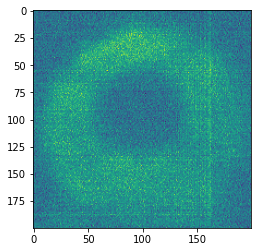

In [97]:
donut = zernikeOutput.donutStampsExtra[7]
plt.imshow(donut.stamp_im.getArrays()[0])

In [103]:
zernikeOutput.outputZernikesRaw[7]


array([-0.01540499, -0.06160212, -0.10774781, -0.01256586,  0.03333587,
       -0.04307701,  0.05463733, -0.00404744,  0.00318675,  0.00304737,
        0.00830958,  0.00918287, -0.02538812, -0.00513388,  0.00068482,
       -0.00326566,  0.04342801,  0.00227987,  0.0020678 ])

In [87]:
zerCoeff = zernikeOutput.outputZernikesAvg

In [98]:
zerCoeff

array([ 2.47260417e-02, -7.32795073e-02, -8.76606725e-02, -4.26394748e-02,
       -1.46299205e-01, -3.64879912e-02,  5.83223837e-02, -8.44319061e-04,
        2.12073857e-03,  7.91765445e-03,  1.12707021e-02,  1.04426167e-02,
        2.65352092e-03, -2.42262088e-03, -4.06450768e-03, -1.05796670e-04,
        5.16120256e-03, -1.81081416e-04,  1.98741789e-03])

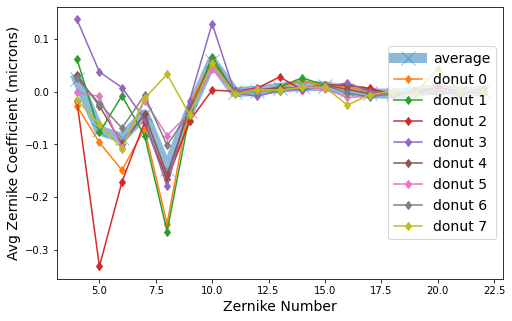

In [124]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8, 5))
# I'm not sure about the OPD values to compare to... 
#plt.plot(np.arange(4, 23), opdVals[85], '-o', lw=3, markersize=10, label='OPD')
plt.plot(np.arange(4, 23),  zernikeOutput.outputZernikesAvg, '-x', lw=10,alpha=0.5, markersize=14, label='average')
for i in [0,1,2,3,4,5,6,7]:
    plt.plot(np.arange(4, 23),zernikeOutput.outputZernikesRaw[i], '-d', label=f'donut {i}')
    plt.xlabel('Zernike Number', size=14)
    plt.ylabel('Avg Zernike Coefficient (microns)', size=14)
plt.legend(fontsize=14, loc='center right')

Text(0.5, 1.0, 'Intra')

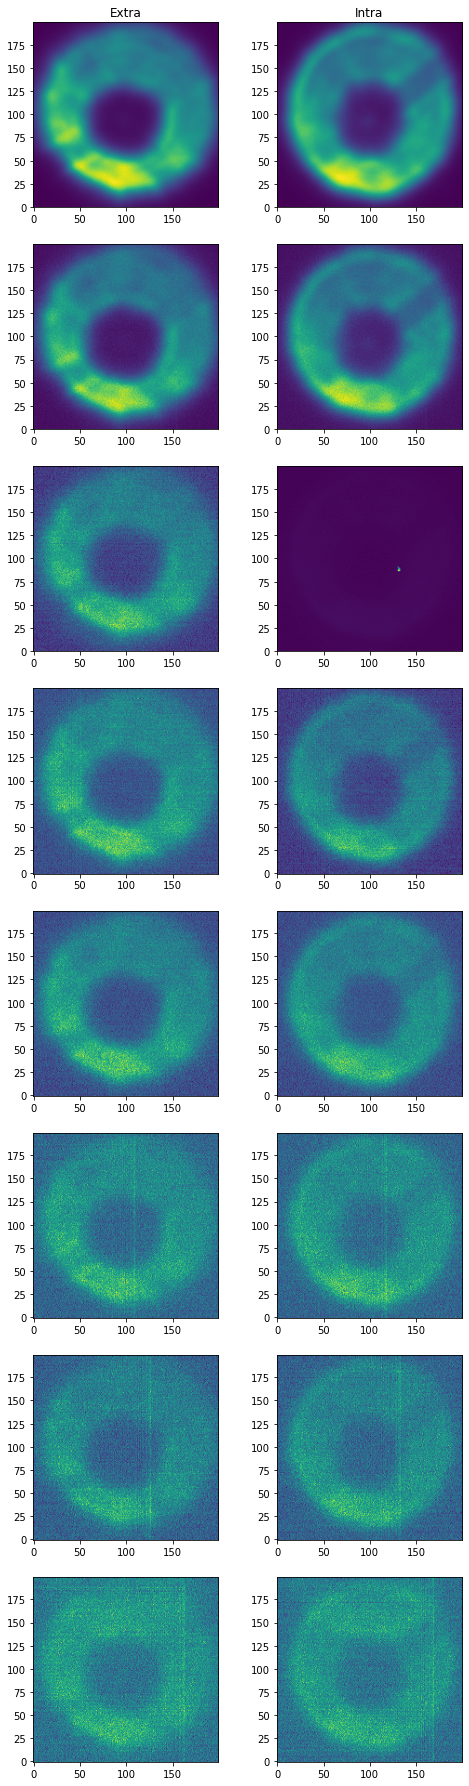

In [118]:
fig,ax = plt.subplots(8,2,figsize=(8,4*8))

for i in range(len(zernikeOutput.donutStampsExtra)):
    donut = zernikeOutput.donutStampsExtra[i]
    ax[i,0].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    
    donut = zernikeOutput.donutStampsIntra[i]
    ax[i,1].imshow(donut.stamp_im.getArrays()[0], origin='lower')
ax[0,0].set_title('Extra')
ax[0,1].set_title('Intra')